In [1]:
import scanpy as sc
import graph_tool.all as gt
import schist
import seaborn as sns
import pandas as pd
import anndata
import pickle
import mygene
import scipy.stats
import statsmodels.api as sm
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata=sc.read('../../scRNA_paga/state_adata/10XV3_minimize.h5ad')

In [41]:
adata=sc.read('../../scRNA_paga/state_adata/10XV3_equilibrate.h5ad')

In [7]:
sc.settings.set_figure_params(dpi=300, facecolor='white')

<BarContainer object of 10 artists>

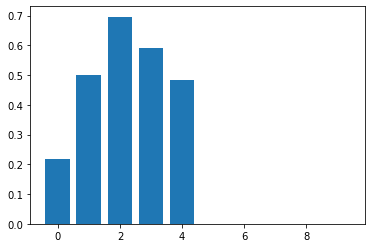

In [3]:
modularity=[x for x in adata.uns['nsbm']['stats']['modularity']]
levels=[x for x in range(len(modularity))]
bar(levels,modularity)

In [89]:
M=adata.uns['nsbm']['cell_affinity']['1']
adata.obs['max_u'] = 1 - np.max(M, axis=1)

In [95]:
adata_affinity=adata[adata.obs.max_u < 1e-10]

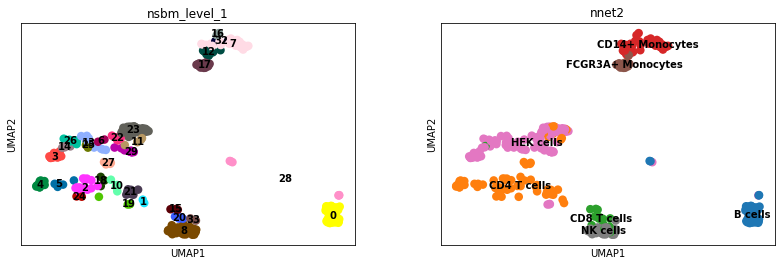

In [96]:
sc.pl.umap(adata_affinity,color=['nsbm_level_1','nnet2'], legend_loc='on data')

In [36]:
sc.tl.leiden(adata, resolution=0.74)

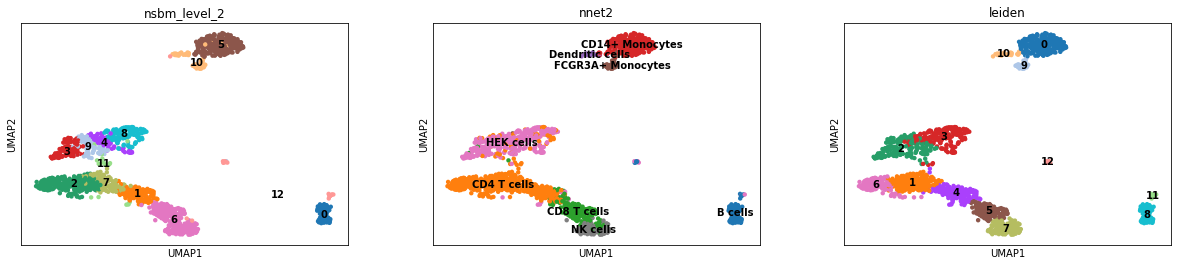

In [224]:
sc.pl.umap(adata,color=['nsbm_level_2','nnet2','leiden'],legend_loc='on data')

In [221]:
level = '2'
marginals = adata.uns['nsbm']['cell_affinity'][level] 
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])

In [222]:
n_cell = adata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)

D = np.array([adata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])

p = D / n_cell
p = p.T

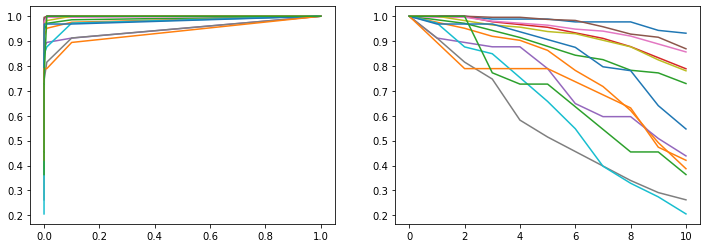

In [223]:
figure(figsize=(12, 4))
subplot(1,2,1)
for x in p:
    plot( thr,x)
subplot(1,2,2)
for x in p:
    plot(x)

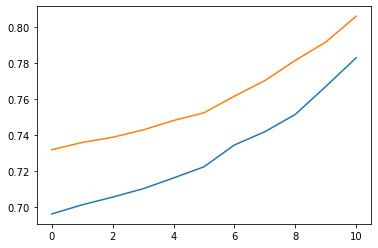

In [175]:
import sklearn
thr = np.array([ 10**-x for x in range(0, 11)])
mi_nsbm=list()
mi_leiden=list()
for i in thr:
    subdata=adata[adata.obs.max_u < i]
    mi_nsbm.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.nsbm_level_2, subdata.obs.nnet2))
    mi_leiden.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.leiden, subdata.obs.nnet2))
plot(mi_nsbm)
plot(mi_leiden)

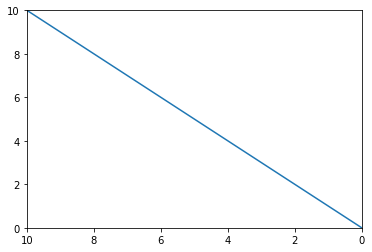

In [40]:
fig, ax = subplots(ncols=1)
ax.set_xlim([10,0])
ax.set_ylim([0, 10])


x = np.linspace(*ax.get_xlim())
ax.plot(x, x)



In [176]:
p[0]

array([1.        , 1.        , 1.        , 0.98863636, 0.98863636,
       0.98863636, 0.97727273, 0.97727273, 0.97727273, 0.94318182,
       0.93181818])

In [177]:
median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])

In [94]:
mean(p[8]-median)

0.2849040867389492

In [5]:
edata=adata

In [115]:
edata.obs['flat']=edata.obs.nsbm_level_2=='0'

In [117]:
edata.obs.flat

10X2x5K_64221_AAACCTGCACTTCGAA     True
10X2x5K_64221_AAACCTGCAGTACACT    False
10X2x5K_64221_AAACCTGTCCACTGGG    False
10X2x5K_64221_AAACGGGAGGTGGGTT    False
10X2x5K_64221_AAACGGGCACACGCTG    False
                                  ...  
10X2x5K_64221_TTTGGTTAGCGTAGTG    False
10X2x5K_64221_TTTGGTTGTGTGTGCC    False
10X2x5K_64221_TTTGTCACACGGACAA    False
10X2x5K_64221_TTTGTCACATTCTCAT    False
10X2x5K_64221_TTTGTCAGTCTAGGTT    False
Name: flat, Length: 1523, dtype: bool

In [152]:
a=pd.Series(edata.obs.nsbm_level_2[edata.obs.nsbm_level_2=='0'], index=edata.obs.nsbm_level_2.index[edata.obs.nsbm_level_2=='0'])

In [154]:
a=a.replace(group_names[0],str(level+'_'+group_names[0]))

In [155]:
a

10X2x5K_64221_AAACCTGCACTTCGAA    2_0
10X2x5K_64221_AACGTTGCAGCTGTTA    2_0
10X2x5K_64221_AACTCCCCAATTGCTG    2_0
10X2x5K_64221_AAGACCTGTCAATGTC    2_0
10X2x5K_64221_ACAGCTACAGCTCGCA    2_0
                                 ... 
10X2x5K_64221_TTAGGCAGTTGCGTTA    2_0
10X2x5K_64221_TTAGTTCCAAAGAATC    2_0
10X2x5K_64221_TTCTACAAGTAGCCGA    2_0
10X2x5K_64221_TTTGCGCGTCGACTAT    2_0
10X2x5K_64221_TTTGCGCGTCGGCATC    2_0
Name: nsbm_level_2, Length: 88, dtype: category
Categories (13, object): [2_0, 1, 2, 3, ..., 9, 10, 11, 12]

In [127]:
b=pd.Series(edata.obs.nsbm_level_2[edata.obs.nsbm_level_2=='1'], index=edata.obs.nsbm_level_2.index[edata.obs.nsbm_level_2=='1'])

In [128]:
pd.Series.append(a, b, ignore_index=False, verify_integrity=True)

10X2x5K_64221_AAACCTGCACTTCGAA    0
10X2x5K_64221_AACGTTGCAGCTGTTA    0
10X2x5K_64221_AACTCCCCAATTGCTG    0
10X2x5K_64221_AAGACCTGTCAATGTC    0
10X2x5K_64221_ACAGCTACAGCTCGCA    0
                                 ..
10X2x5K_64221_TTAGTTCTCTGTCTAT    1
10X2x5K_64221_TTCTACATCACGACTA    1
10X2x5K_64221_TTCTCCTCAGTCTTCC    1
10X2x5K_64221_TTGAACGCAAAGCGGT    1
10X2x5K_64221_TTGCCGTAGCACCGCT    1
Name: nsbm_level_2, Length: 212, dtype: category
Categories (13, object): [0, 1, 2, 3, ..., 9, 10, 11, 12]

In [202]:
edata=adata

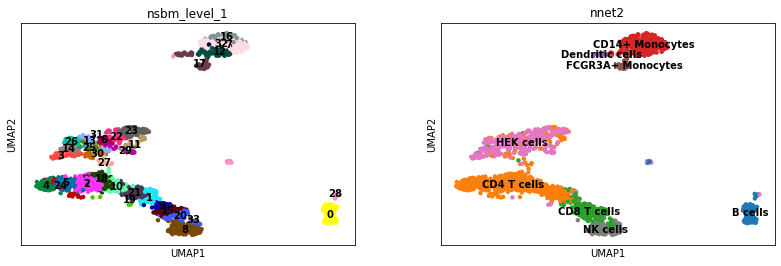

In [205]:
sc.pl.umap(edata, color=['nsbm_level_1','nnet2'],legend_loc='on data')

In [157]:
flat=pd.Series()
flat

<ipython-input-157-07ac5743dac5>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


Series([], dtype: float64)

In [38]:
cdata=adata.copy()
flat=pd.Series()

<ipython-input-38-e9aa9f4cb1b4>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


In [39]:
for i in range(1,len(cdata.uns['nsbm']['cell_affinity'])):
    level = str(i)
    marginals = cdata.uns['nsbm']['cell_affinity'][level] 
    group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
    Max = marginals[marginals < 1].max()
    Min = marginals[marginals > 0].min()
    thr = np.linspace(Min, Max, 10)
    thr = np.array([ 10**-x for x in range(0, 11)])
    n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
    cell_aff = np.max(marginals, axis=1)
    D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
    p = D / n_cell
    p = p.T
    median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
    del_aff=[]
    for group in group_names:
        group_sign=mean(p[int(group)]-median)
        if group_sign>0.25:
            a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
            a=a.replace(group,str(level+'_'+group))
            flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
            del_affinities_g=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]==group]
            del_aff.append(del_affinities)
            cdata=cdata[cdata.obs[f'nsbm_level_{level}']!=group]
    for i in cdata.uns['nsbm']['cell_affinity']:
        cdata.uns['nsbm']['cell_affinity'][i]=np.delete(cdata.uns['nsbm']['cell_affinity'][i], del_aff,axis=0)
           
            


IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (1399,) while AnnData index has shape (1110,).

In [41]:
cdata.obs[f'nsbm_level_{level}']!=group

10X2x5K_64221_AAACCTGCAGTACACT    True
10X2x5K_64221_AAACCTGTCCACTGGG    True
10X2x5K_64221_AAACGGGCACACGCTG    True
10X2x5K_64221_AAACGGGCACCAGCAC    True
10X2x5K_64221_AAACGGGGTGAAAGAG    True
                                  ... 
10X2x5K_64221_TTTGCGCCATCAGTAC    True
10X2x5K_64221_TTTGGTTAGCGTAGTG    True
10X2x5K_64221_TTTGTCACACGGACAA    True
10X2x5K_64221_TTTGTCACATTCTCAT    True
10X2x5K_64221_TTTGTCAGTCTAGGTT    True
Name: nsbm_level_2, Length: 1110, dtype: bool

In [25]:
del_affinities=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]=='1']

In [42]:
flat

10X2x5K_64221_AAACCTGCACTTCGAA     1_0
10X2x5K_64221_AACGTTGCAGCTGTTA     1_0
10X2x5K_64221_AACTCCCCAATTGCTG     1_0
10X2x5K_64221_AAGACCTGTCAATGTC     1_0
10X2x5K_64221_ACAGCTACAGCTCGCA     1_0
                                  ... 
10X2x5K_64221_CGGACTGTCCATGCTC    1_32
10X2x5K_64221_GTGCTTCGTCACCTAA    1_32
10X2x5K_64221_TGAGCATGTTCTCATT    1_32
10X2x5K_64221_CGGTTAATCCAAAGTC    1_33
10X2x5K_64221_GTTCTCGAGTGGAGAA    1_33
Length: 413, dtype: object

<ipython-input-4-bdab5851a3cb>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
... storing 'flat' as categorical


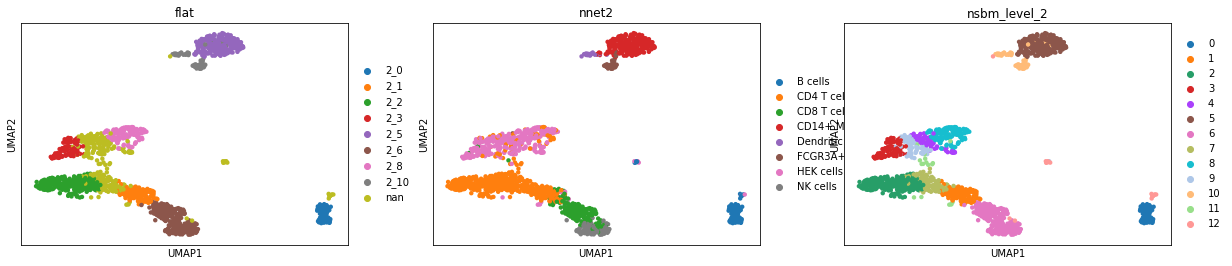

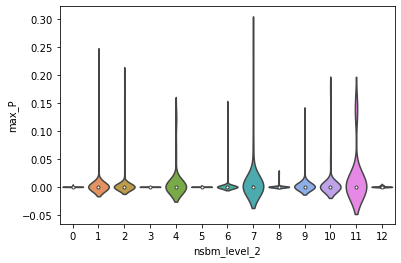

In [4]:
cdata=adata
flat=pd.Series()
level = str(2)
marginals = cdata.uns['nsbm']['cell_affinity'][level] 
group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])
n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)
D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
p = D / n_cell
p = p.T
median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
for group in group_names:
    group_sign=mean(p[int(group)]-median)
    if group_sign>0.25:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
        a=a.replace(group,str(level+'_'+group))
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        del_affinities=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]==group]
        for i in cdata.uns['nsbm']['cell_affinity']:
            cdata.uns['nsbm']['cell_affinity'][i]=np.delete(cdata.uns['nsbm']['cell_affinity'][i], del_affinities,axis=0)
        cdata=cdata[cdata.obs[f'nsbm_level_{level}']!=group]
            
adata.obs['flat']=flat
sc.pl.umap(adata, color=['flat','nnet2',f'nsbm_level_{level}'])
#sns.barplot(data=-log10(marginals))
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs, scale='width')

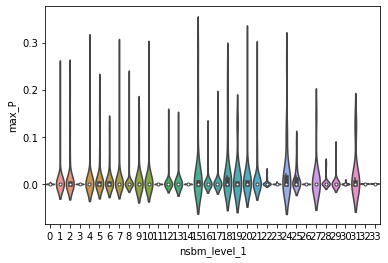

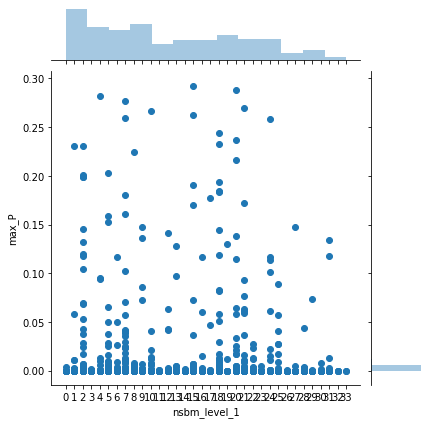

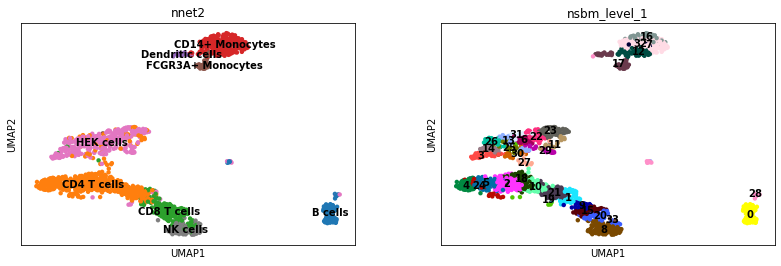

In [4]:
fdata=adata
level=str(1)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs,scale='width')
sns.jointplot(x=f'nsbm_level_{level}' , y='max_P', data=fdata.obs)
sc.pl.umap(adata, color=['nnet2',f'nsbm_level_{level}'],legend_loc='on data')

In [5]:
import seaborn as sns


In [47]:
fdata=adata

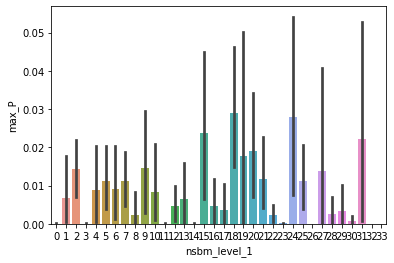

In [8]:
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.barplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs)

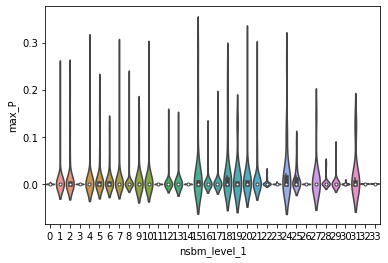

In [7]:
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs, scale='width')

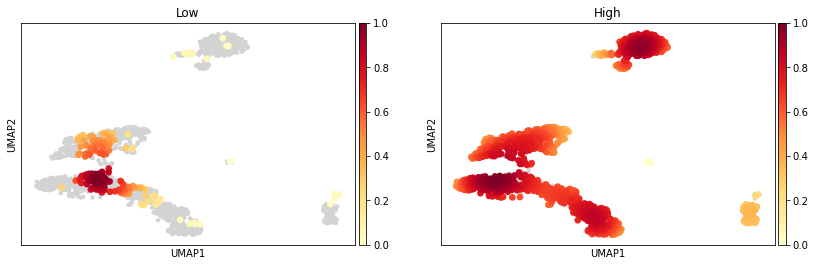

In [16]:
fdata=adata
level=str(2)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
d = pd.Categorical(np.max(marginals, axis=1) > (1 - 1e-5))
d.rename_categories(['Low', 'High'], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

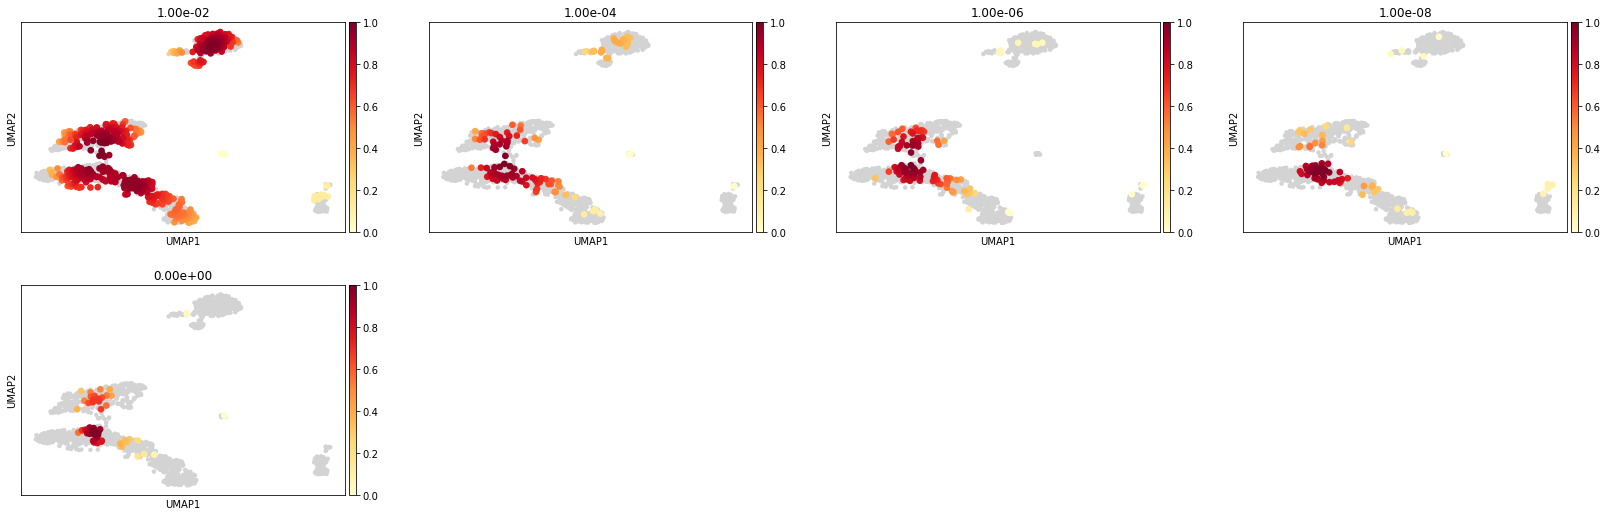

In [195]:
cuts = [0]+ [10**-x for x in range(0, 10, 2)][::-1]
d = pd.Categorical(pd.cut(1-np.max(marginals, axis=1), cuts))
d.rename_categories([f'{x:.2e}' for x in cuts[:-1]][::-1], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

In [42]:
cdata=adata.copy()
flat=pd.Series()

<ipython-input-42-e9aa9f4cb1b4>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


In [6]:
for i in range(1,len(cdata.uns['nsbm']['cell_affinity'])):
    level = str(i)
    marginals = cdata.uns['nsbm']['cell_affinity'][level] 
    group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
    try:
        Max = marginals[marginals < 1].max()
        Min = marginals[marginals > 0].min()
        thr = np.linspace(Min, Max, 10)
        thr = np.array([ 10**-x for x in range(0, 11)])
        n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
        cell_aff = np.max(marginals, axis=1)
        D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
        p = D / n_cell
        p = p.T
        median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
        for group in group_names:
            group_sign=mean(p[int(group)]-median)
            if group_sign>0.25:
                a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
                a=a.replace(group,str(level+'_'+group))
                flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=False)
    except ValueError: 
        continue
flat = flat.loc[~flat.index.duplicated(keep='first')]
fdata.obs['flat']=flat
sc.pl.umap(fdata, color=['flat','nnet2','nsbm_level_2'],legend_loc='on data')

IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (1435,) while AnnData index has shape (274,).

In [5]:
for i in range(1,len(cdata.uns['nsbm']['cell_affinity'])):
    level = str(i)
    marginals = cdata.uns['nsbm']['cell_affinity'][level] 
    group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
    try:
        Max = marginals[marginals < 1].max()
        Min = marginals[marginals > 0].min()
        thr = np.linspace(Min, Max, 10)
        thr = np.array([ 10**-x for x in range(0, 11)])
        n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
        cell_aff = np.max(marginals, axis=1)
        D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
        p = D / n_cell
        p = p.T
        median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
        for group in group_names:
            group_sign=mean(p[int(group)]-median)
            if group_sign>0:
                a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
                a=a.replace(group,str(level+'_'+group))
                flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=False)
    except ValueError: 
        continue
flat = flat.loc[~flat.index.duplicated(keep='first')]
adata.obs['flat']=flat
sc.pl.umap(adata, color=['flat','nnet2','nsbm_level_2'],legend_loc='on data')

IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (1435,) while AnnData index has shape (274,).

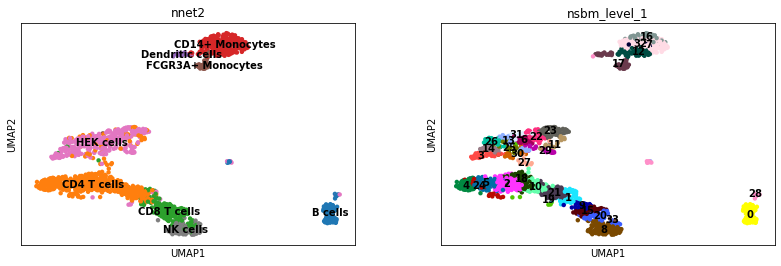

In [5]:
sc.pl.umap(adata,color=['nnet2','nsbm_level_1'],legend_loc='on data')
marginals = adata.uns['nsbm']['cell_affinity']['1'] 
adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))

In [7]:
adata0=adata[adata.obs['nsbm_level_1']=='0']

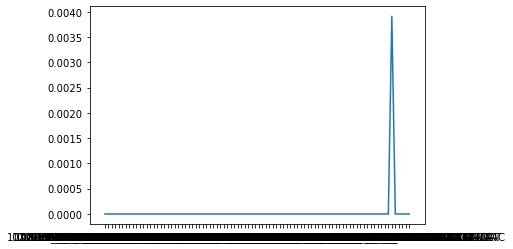

In [8]:
plot(adata0.obs['max_P'])

In [64]:
mean(adata0.obs['max_P'])

0.002452779838516788

In [61]:
mean(adata0.obs['max_P'])

0.015534733295480344

In [58]:
mean(adata0.obs['max_P'])

0.003500122020485582

In [55]:
mean(adata0.obs['max_P'])

0.007110671143642825

In [52]:
mean(adata0.obs['max_P'])

0.0008135949409538152

In [48]:
sum(adata0.obs['max_P'])/len(adata0.obs['max_P'])

0.020102077445017682

In [45]:
sum(adata0.obs['max_P'])/len(adata0.obs['max_P'])

0.012140919972964948

In [42]:
sum(adata0.obs['max_P'])/len(adata0.obs['max_P'])

0.008318029645926386

In [39]:
sum(adata0.obs['max_P'])/len(adata0.obs['max_P'])

0.009630868704146962

In [36]:
sum(adata0.obs['max_P'])/len(adata0.obs['max_P'])

6.320674983457364e-05

In [33]:
sum(adata0.obs['max_P'])/len(adata0.obs['max_P'])

0.013640932275843865

In [30]:
sum(adata0.obs['max_P'])/len(adata0.obs['max_P'])

0.0098012948128984

In [22]:
sum(adata0.obs['max_P'])/len(adata0.obs['max_P'])

4.445131932342261e-05

In [23]:
adata0.obs['max_P']

10X2x5K_64221_AAACCTGCACTTCGAA   -0.000000e+00
10X2x5K_64221_AACGTTGCAGCTGTTA   -0.000000e+00
10X2x5K_64221_AACTCCCCAATTGCTG   -0.000000e+00
10X2x5K_64221_AAGACCTGTCAATGTC    4.381615e-12
10X2x5K_64221_ACAGCTACAGCTCGCA   -0.000000e+00
                                      ...     
10X2x5K_64221_TTAGGCAGTTGCGTTA   -0.000000e+00
10X2x5K_64221_TTAGTTCCAAAGAATC   -0.000000e+00
10X2x5K_64221_TTCTACAAGTAGCCGA   -0.000000e+00
10X2x5K_64221_TTTGCGCGTCGACTAT    2.025088e-15
10X2x5K_64221_TTTGCGCGTCGGCATC   -0.000000e+00
Name: max_P, Length: 88, dtype: float64

<ipython-input-20-79f32dddc1e8>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


0
1
2
3
5
6
8
9
10
12


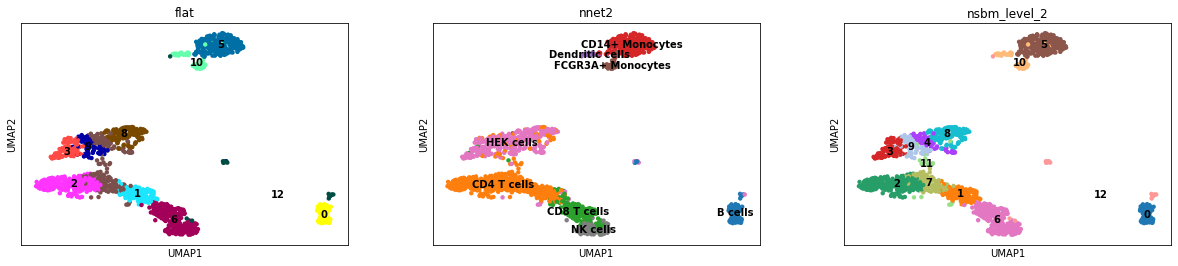

[1.0, 0.9758064516129032, 0.9822064056939501, 1.0, 0.9122807017543859, 1.0, 0.9960159362549801, 0.9029126213592233, 0.9824561403508771, 0.9726027397260274, 0.96875, 0.8947368421052632, 1.0]


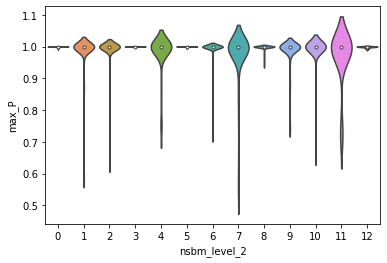

In [20]:
level=str(2)
marginals = adata.uns['nsbm']['cell_affinity'][level] 
#adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
adata.obs['max_P'] = np.max(marginals,axis=1)
group_sig=[]
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
for group in group_names:
    adata0=adata[adata.obs[f'nsbm_level_{level}']==group]
    c=0
    for i in adata0.obs['max_P']:
#        if i<0.05:
        if i>0.95:
            c=c+1
    c=c/(len(adata0.obs['max_P']))
    group_sig.append(c)
cdata=adata
flat=pd.Series()
for i in range(len(group_sig)):
#    if group_sig[i]<0.05:
    if group_sig[i]>0.95:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==str(i)], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==str(i)])
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        print(i)
cdata.obs['flat']=flat
sc.pl.umap(cdata, color=['flat','nnet2',f'nsbm_level_{level}'],legend_loc='on data')
print(group_sig)

sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = adata.obs, scale='width')

<ipython-input-21-a8ff4d383f77>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


0
1
2
3
5
6
8
9
10
12


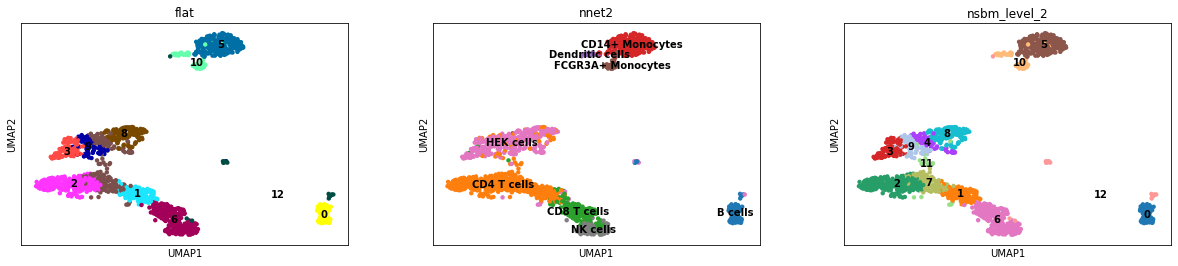

[0.0, 0.024193548387096774, 0.014234875444839857, 0.0, 0.08771929824561403, 0.0, 0.00398406374501992, 0.08737864077669903, 0.0, 0.0273972602739726, 0.015625, 0.10526315789473684, 0.0]


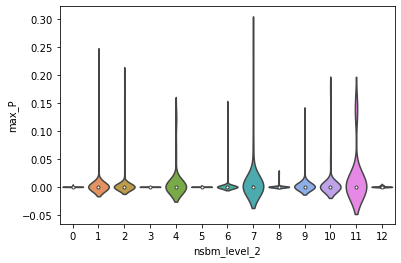

In [21]:
level=str(2)
marginals = adata.uns['nsbm']['cell_affinity'][level] 
adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
#adata.obs['max_P'] = np.max(marginals,axis=1)
group_sig=[]
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
for group in group_names:
    adata0=adata[adata.obs[f'nsbm_level_{level}']==group]
    c=0
    for i in adata0.obs['max_P']:
        if i>0.05:
#        if i>0.95:
            c=c+1
    c=c/(len(adata0.obs['max_P']))
    group_sig.append(c)
cdata=adata
flat=pd.Series()
for i in range(len(group_sig)):
    if group_sig[i]<0.05:
#    if group_sig[i]>0.95:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==str(i)], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==str(i)])
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        print(i)
cdata.obs['flat']=flat
sc.pl.umap(cdata, color=['flat','nnet2',f'nsbm_level_{level}'],legend_loc='on data')
print(group_sig)

sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = adata.obs, scale='width')

In [29]:
for i in range(len(adata.uns['nsbm']['cell_affinity']['2'])):
    if sum(adata.uns['nsbm']['cell_affinity']['2'][i]) <0.9:
        print(i,'è diversooo')

In [27]:
sum(adata.uns['nsbm']['cell_affinity']['2'][1492])

0.9999999999999999